In [1]:
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [16]:
import sys
sys.path.append('../code')
import data_processing as dp
import feats_targs_binned_pct as ftbp

import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [107]:
top_stocks = ftbp.get_top_stocks(num=100)
dfs, _, _ = dp.load_stocks(stocks=top_stocks,
                           finra_shorts=False,
                           short_interest=False,
                           earliest_date=None,
                           calc_scores=False)

loading stocks...
calculating TAs...


In [108]:
latest_date, ld_df = ftbp.get_latest_earliest_date(dfs)

for s in dfs.keys():
    # standardize to latest date so they all have the same earliest time
    dfs[s] = dfs[s][dfs[s].index > latest_date]

ftbp.drop_cols(dfs, ignore_all=True)

ftbp.make_ohlcv_feats_targs_multithread(dfs, threshold=0.01)

GGP
LNG
AKS
CHK
AMD
CAR
OLED
INCY
SIRI
MU
SWKS
MT
NKTR
X
ETFC
FCX
VRX
REGN
WDC
VRTX
URI
CY
RIG
MSCC
AIG
AKAM
RRC
MGM
ANDV
SWN
TER
NVDA
WMB
BBY
LRCX
GG
FFIV
STLD
ALXN
NOV
NTAP
RIO
PHM
BKNG
ABX
DHI
ADSK
CELG
BMRN
SIG
CGNX
MOS
TTWO
RCL
HIG
ASML
LEN
MS
JNPR
AMAT
AABA
PXD
CTXS
HP
BIIB
HOLX
SBAC
EA
HAL
AMZN
MNST
HFC
KLAC
AMTD
C
KMX
COG
ALK
LNC
RHT
NEM
SCHW
SIVB
VLO
APC
DVN
BHP
IVZ
M
ADBE
AAPL
TOL
COHR
GLW
SYMC
APA
ATVI
JWN
NVR
COF
SPY
UPRO
QQQ
TQQQ
DIA
UBT


In [109]:
train_features, test_features, train_targets, test_targets, feat_labels, targ_labels = ftbp.get_features_targets_deep(dfs)

In [110]:
ftbp.get_no_info_rate(train_targets, targ_labels)

no info rate: 0.6163165159551344


In [111]:
train_features.shape

(184016, 147)

In [112]:
train_targets.shape

(184016, 20)

In [113]:
test_features.shape

(20458, 147)

In [114]:
from keras.layers import Input, Dense, Dropout, BatchNormalization, LSTM, Conv1D, MaxPooling1D, Activation, Flatten, Concatenate, Reshape
from keras.models import Model, load_model
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.regularizers import l1_l2
import keras.backend as K
import keras.losses

In [115]:
# shuffle training data...not sure if a good idea
# seems to be a bad idea
# idxs = np.arange(train_targets.shape[0])
# np.random.shuffle(idxs)
# train_features = train_features[idxs]
# train_targets = train_targets[idxs]

# either scaling or not did not seem to help...

In [159]:
from sklearn.preprocessing import StandardScaler as SS
# try scaling inputs
scalers = []
sc_tr_feats = []
sc_te_feats = []
for i in range(train_features.shape[1]):
    sc = SS()
    sc_tr_feats.append(sc.fit_transform(train_features[:, i].reshape(-1, 1)).flatten())
    sc_te_feats.append(sc.transform(test_features[:, i].reshape(-1, 1)).flatten())
    scalers.append(sc)

In [160]:
sc_tr_feats = np.array(sc_tr_feats)
sc_te_feats = np.array(sc_te_feats)

In [161]:
sc_tr_feats.shape

(147, 184016)

In [162]:
train_features.shape

(184016, 147)

In [163]:
sc_tr_feats = sc_tr_feats.transpose()
sc_te_feats = sc_te_feats.transpose()

In [164]:
sc_tr_feats.shape

(184016, 147)

In [165]:
import tensorflow as tf

In [166]:
K.clear_session()
tf.reset_default_graph()

timesteps = 1
input_dim = train_features.shape[1]
output_dim = train_targets.shape[1]

inputs = Input(shape=(timesteps*input_dim, ))
x = Dense(1000, activation='elu')(inputs)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(500, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(200, activation='elu')(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)
x = Dense(output_dim, activation='sigmoid')(x)

mod = Model(inputs, x)
mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [167]:
mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 147)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              148000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1000)              4000      
_________________________________________________________________
dropout_1 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
_________________________________________________________________
batch_normalization_2 (Batch (None, 500)               2000      
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
__________

In [168]:
es = EarlyStopping(monitor='val_loss', patience=30)

history = mod.fit(sc_tr_feats,
            train_targets,
            epochs=300,
            validation_split=0.1,
            batch_size=10000,
            callbacks=[es])

Train on 165614 samples, validate on 18402 samples
Epoch 1/300
165614/165614 [==============================] - 1s 8us/step - loss: 0.7370 - acc: 0.5139 - val_loss: 0.7103 - val_acc: 0.5287
Epoch 2/300
165614/165614 [==============================] - 1s 6us/step - loss: 0.6908 - acc: 0.5425 - val_loss: 0.6814 - val_acc: 0.5674
Epoch 3/300
165614/165614 [==============================] - 1s 6us/step - loss: 0.6808 - acc: 0.5692 - val_loss: 0.6629 - val_acc: 0.6113
Epoch 4/300
165614/165614 [==============================] - 1s 6us/step - loss: 0.6733 - acc: 0.5885 - val_loss: 0.6497 - val_acc: 0.6426
Epoch 5/300
165614/165614 [==============================] - 1s 6us/step - loss: 0.6667 - acc: 0.6013 - val_loss: 0.6401 - val_acc: 0.6536
Epoch 6/300
165614/165614 [==============================] - 1s 6us/step - loss: 0.6618 - acc: 0.6081 - val_loss: 0.6319 - val_acc: 0.6587
Epoch 7/300
165614/165614 [==============================] - 1s 6us/step - loss: 0.6590 - acc: 0.6118 - val_loss: 0

Text(0,0.5,'val accuracy')

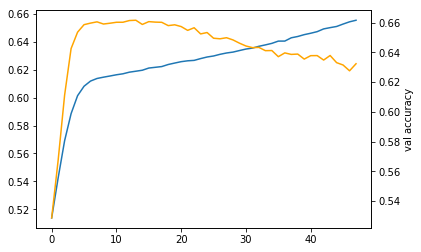

In [169]:
fig, ax1 = plt.subplots()
_ = ax1.plot(history.history['acc'])
ax2 = ax1.twinx()
_ = ax2.plot(history.history['val_acc'], c='orange')
ax2.set_ylabel('val accuracy')

In [177]:
mod.evaluate(sc_tr_feats, train_targets)

184016/184016 [==============================] - 13s 70us/step


[0.6158596734908983, 0.663741740156553]

In [182]:
mod.evaluate(sc_te_feats, test_targets)

20458/20458 [==============================] - 1s 72us/step


[0.6712786947390774, 0.6086225454519892]

In [183]:
len(top_stocks)

106

In [179]:
train_preds = mod.predict(sc_tr_feats)
test_preds = mod.predict(sc_te_feats)

0.6700398967639424


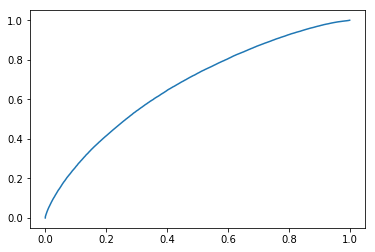

In [180]:
fpr, tpr, _ = roc_curve(train_targets[:, 8], train_preds[:, 8])
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

0.5008694250370649


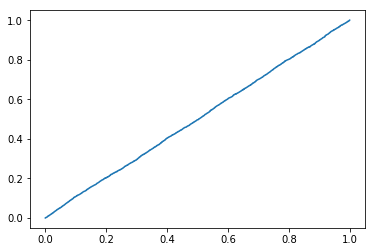

In [181]:
fpr, tpr, _ = roc_curve(test_targets[:, 8], test_preds[:, 8])
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

# try with SVM

In [3]:
top_stocks = ftbp.get_top_stocks(num=1, indices=False)
dfs, _, _ = dp.load_stocks(stocks=top_stocks,
                           finra_shorts=False,
                           short_interest=False,
                           earliest_date=None,
                           calc_scores=False)

loading stocks...
calculating TAs...


In [4]:
ftbp.drop_cols(dfs, ignore_all=True)

ftbp.make_ohlcv_feats_targs_multithread(dfs, threshold=0.01)

GGP


In [5]:
train_features, test_features, train_targets, test_targets, feat_labels, targ_labels = ftbp.get_features_targets_deep(dfs)

In [6]:
train_features.shape

(5555, 147)

In [7]:
ftbp.get_no_info_rate(train_targets, targ_labels)

no info rate: 0.6536633663366337


In [8]:
from sklearn.svm import SVC

In [9]:
targ_labels

['Adj_Close_pct_change_f=1_gt_0.01',
 'Adj_Close_pct_change_f=1_lt_-0.01',
 'Adj_Close_pct_change_f=2_gt_0.01',
 'Adj_Close_pct_change_f=2_lt_-0.01',
 'Adj_Close_pct_change_f=3_gt_0.01',
 'Adj_Close_pct_change_f=3_lt_-0.01',
 'Adj_Close_pct_change_f=4_gt_0.01',
 'Adj_Close_pct_change_f=4_lt_-0.01',
 'Adj_Close_pct_change_f=5_gt_0.01',
 'Adj_Close_pct_change_f=5_lt_-0.01',
 'Adj_Close_pct_change_f=6_gt_0.01',
 'Adj_Close_pct_change_f=6_lt_-0.01',
 'Adj_Close_pct_change_f=7_gt_0.01',
 'Adj_Close_pct_change_f=7_lt_-0.01',
 'Adj_Close_pct_change_f=8_gt_0.01',
 'Adj_Close_pct_change_f=8_lt_-0.01',
 'Adj_Close_pct_change_f=9_gt_0.01',
 'Adj_Close_pct_change_f=9_lt_-0.01',
 'Adj_Close_pct_change_f=10_gt_0.01',
 'Adj_Close_pct_change_f=10_lt_-0.01']

In [10]:
import time

In [37]:
start = time.time()
clf = SVC(C=1, gamma=0.01)
clf.fit(train_features, train_targets[:, 8])
end = time.time()
print('took', int(end - start), 'seconds')

took 3 seconds


In [38]:
clf.score(train_features, train_targets[:, 8])

1.0

In [39]:
clf.score(test_features, test_targets[:, 8])

0.6245954692556634

In [40]:
train_preds = clf.predict(train_features)
test_preds = clf.predict(test_features)

1.0


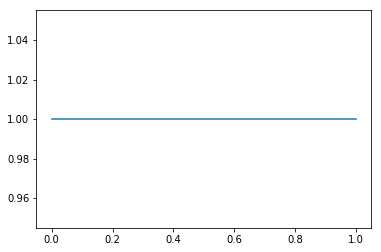

In [41]:
fpr, tpr, _ = roc_curve(train_targets[:, 8], train_preds)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

0.5


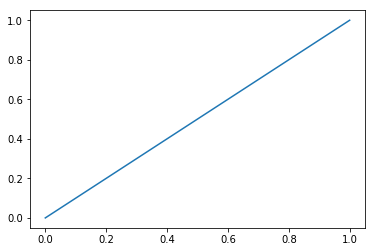

In [42]:
fpr, tpr, _ = roc_curve(test_targets[:, 8], test_preds)
print(auc(fpr, tpr))
plt.plot(fpr, tpr)

In [43]:
dfs.keys()

dict_keys(['GGP'])

In [32]:
import seaborn as sns

In [35]:
dfs['GGP'].columns

Index(['bband_u_cl_diff', 'bband_m_cl_diff', 'bband_l_cl_diff',
       'bband_u_cl_diff_hi', 'bband_l_cl_diff_lo', 'bband_u_tp_diff',
       'bband_m_tp_diff', 'bband_l_tp_diff', 'bband_u_tp_diff_hi',
       'bband_l_tp_diff_lo',
       ...
       'Adj_Close_pct_change_f=6_gt_0.01', 'Adj_Close_pct_change_f=6_lt_-0.01',
       'Adj_Close_pct_change_f=7_gt_0.01', 'Adj_Close_pct_change_f=7_lt_-0.01',
       'Adj_Close_pct_change_f=8_gt_0.01', 'Adj_Close_pct_change_f=8_lt_-0.01',
       'Adj_Close_pct_change_f=9_gt_0.01', 'Adj_Close_pct_change_f=9_lt_-0.01',
       'Adj_Close_pct_change_f=10_gt_0.01',
       'Adj_Close_pct_change_f=10_lt_-0.01'],
      dtype='object', length=167)

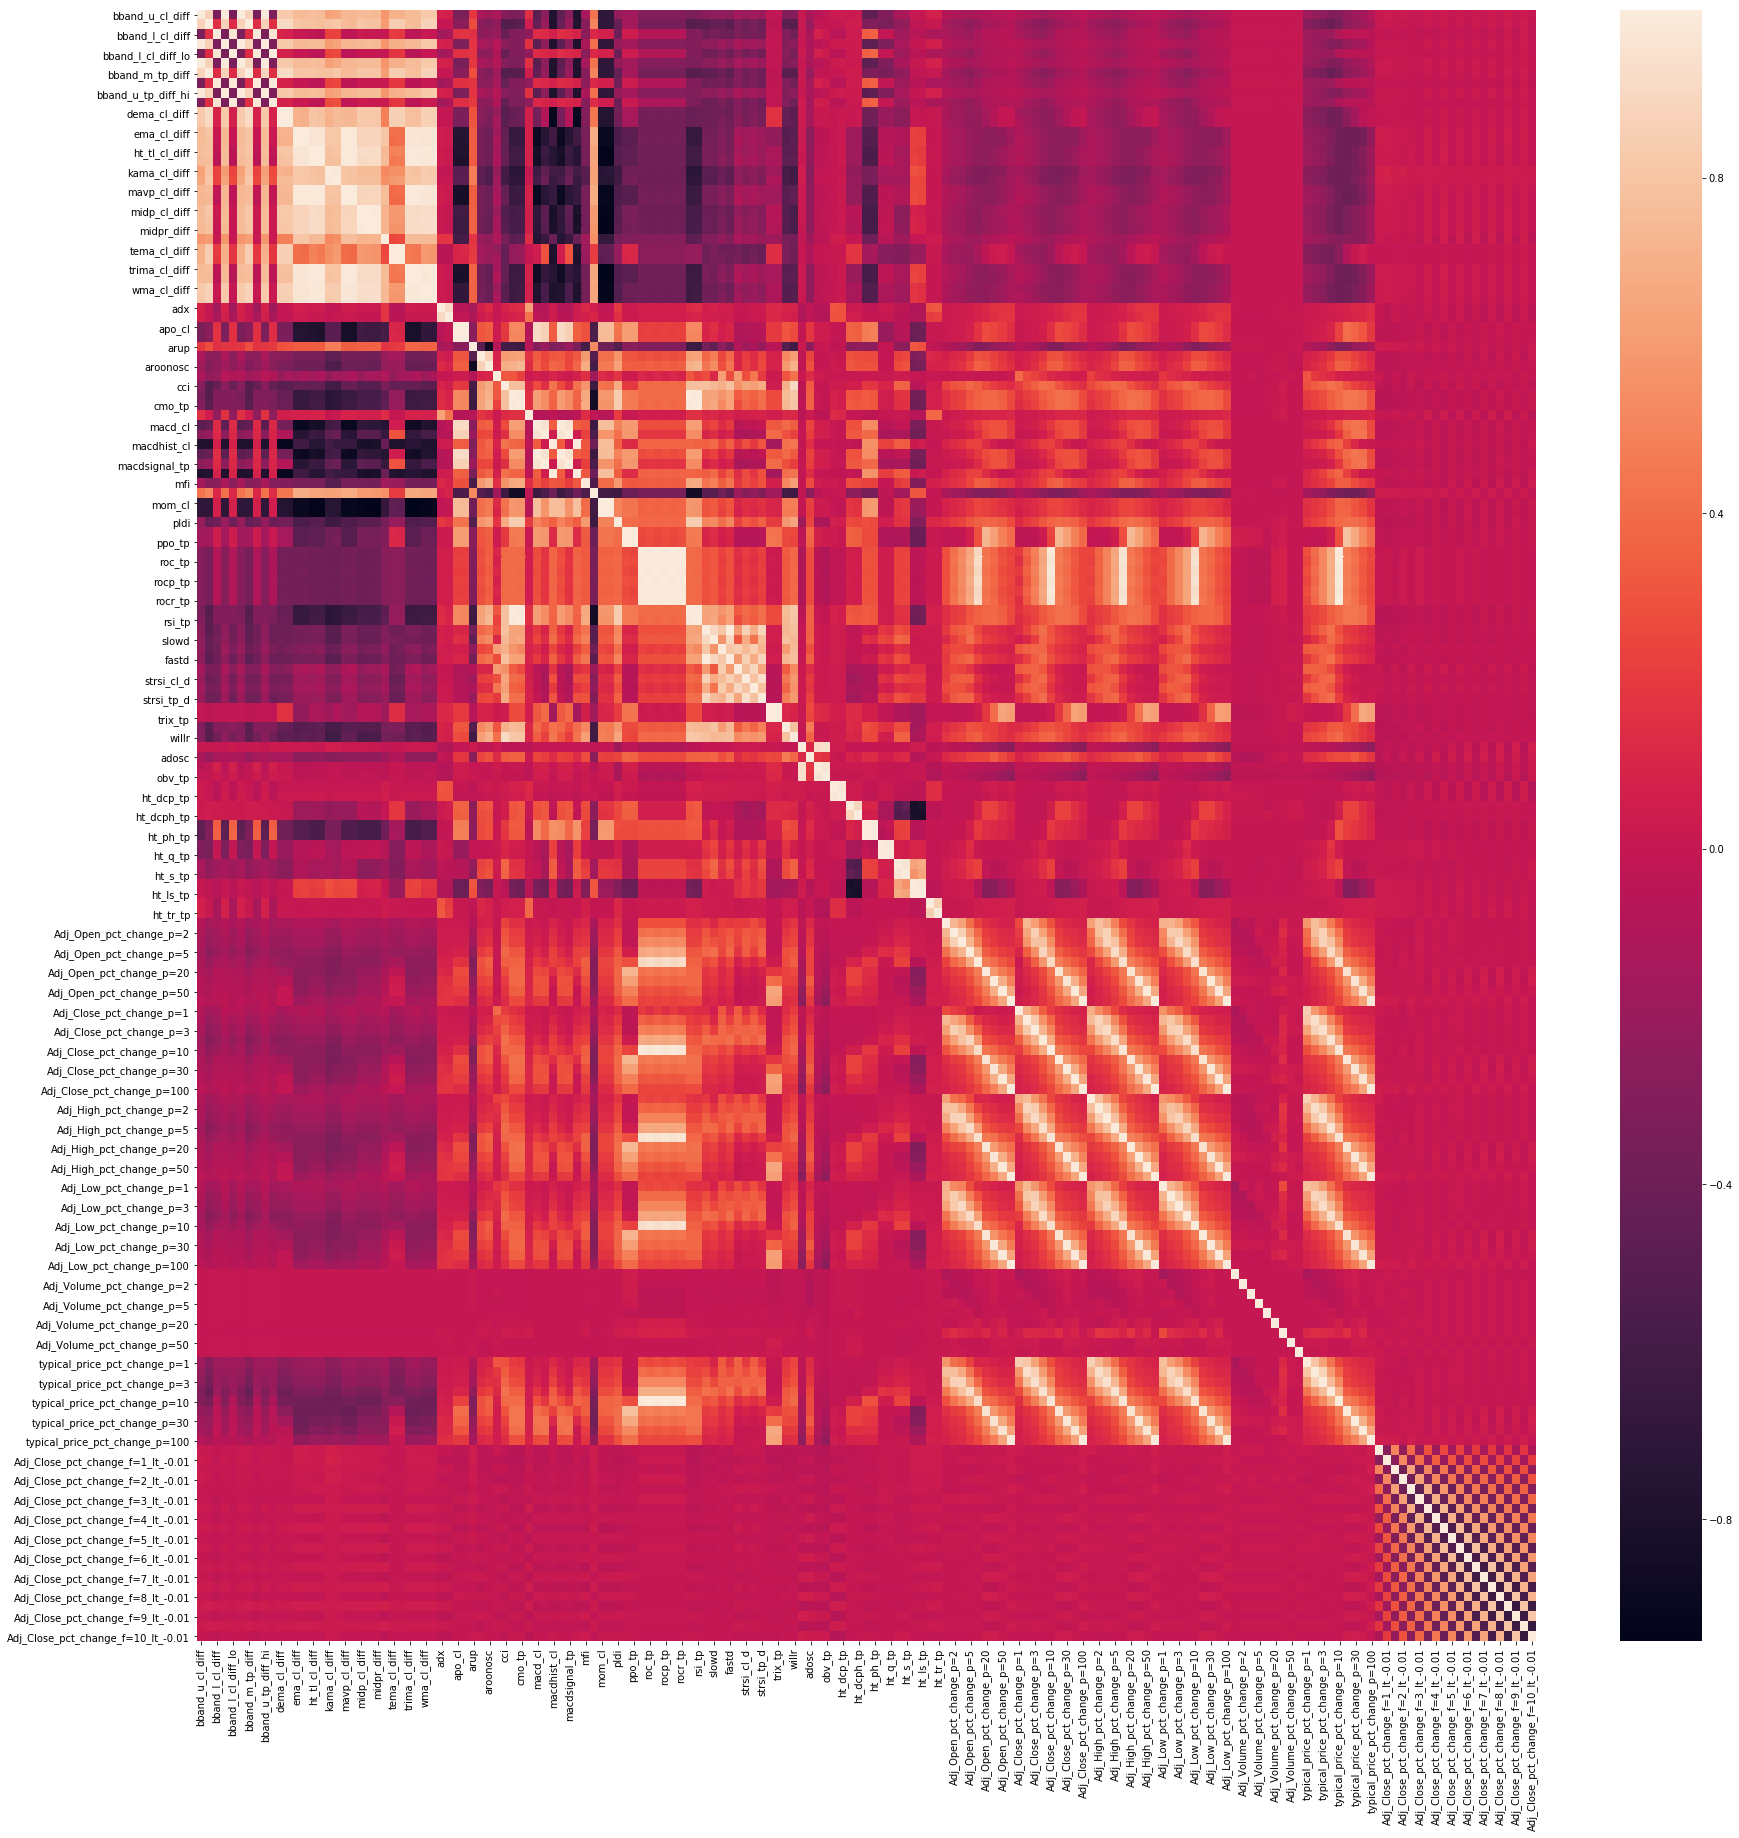

In [36]:
f = plt.figure(figsize=(30, 30))
sns.heatmap(dfs['GGP'].corr())